# CREDIT SCORING
Data downloaded from the site [kaggle.com](https://www.kaggle.com/c/sf-dst-scoring)

September 2022
___

## DESCRIPTION
The task of credit scoring is to predict the probability of a credit default. 
The goal of this project is to choose the most effective model for assessing the quality of the bank's clients.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, plot_confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# keeping experiments reproducible
RANDOM_SEED = 42 
# settings to display all columns
pd.set_option('display.max_columns', None)
# set the color palette
sns.set_palette(sns.color_palette('inferno'))

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
# determining outliers with Z-score (any z-score greater than 3 or less than -3 is considered to be an outlier)
def get_outliers(col, threshold = 3):
    outlier = []
    mean = np.mean(col)
    std = np.std(col)

    for i in col:
        z = (i - mean) / std
        if z > threshold:
            outlier.append(i)
    return outlier
    
# obtaining a percentage of outliers
def get_percent_outliers(col):
    return f"{len(get_outliers(col)) / len(col) * 100:.2f}% outliers"

## Dataset information

In [4]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
# checking the percentage of missing values
df.isnull().sum() / df.shape[0] * 100

client_id           0.000000
app_date            0.000000
education           0.415995
sex                 0.000000
age                 0.000000
car                 0.000000
car_type            0.000000
decline_app_cnt     0.000000
good_work           0.000000
score_bki           0.000000
bki_request_cnt     0.000000
region_rating       0.000000
home_address        0.000000
work_address        0.000000
income              0.000000
sna                 0.000000
first_time          0.000000
foreign_passport    0.000000
default             0.000000
dtype: float64

### Features Defination

- client_id - identification

- education - education level (SCH - School; GRD - Graduated (Master degree); UGR - UnderGraduated (Bachelor degree); PGR  - PostGraduated; ACD - Academic Degree)

- sex - sex

- age - age

- car - binary/ has a car or not

- car_type - whether car is international

- decline_app_cnt - declined application count in the past

- good_work - binary/ has 'good' work or not

- bki_request_cnt - requests to BKI

- home_address - category of home address

- work_address - category of work address

- income - income

- foreign_passport - binary/ has foreign passport

- sna - connection with bank employee

- first_time - age of information about the client

- score_bki - BKI score

- region_rating - region rating

- app_date - application date

- default - default flag

## Exploratory Data Analysis¶

0    64427
1     9372
Name: default, dtype: int64

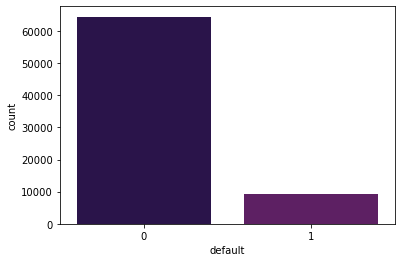

In [8]:
sns.countplot(df['default'])
df['default'].value_counts()

When building a model, it's necessary to take into account the imbalance of classes

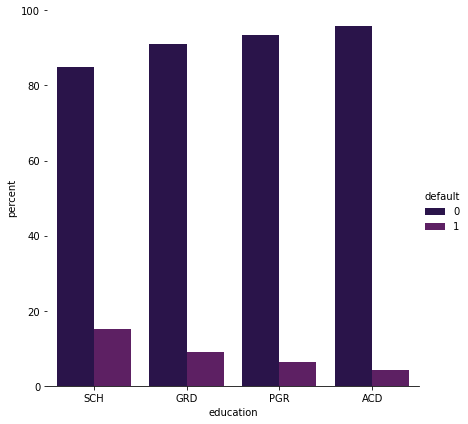

In [9]:
default_by_education = df['default'].groupby(df['education']).value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(x='education', y='percent', hue='default', data=default_by_education, kind='bar', height=6, order=['SCH', 'GRD', 'PGR', 'ACD'])

g.despine(left=True)
g.set_axis_labels('education', 'percent')
g.legend.set_title('default')

Education level negatively correlates with the number of defaults

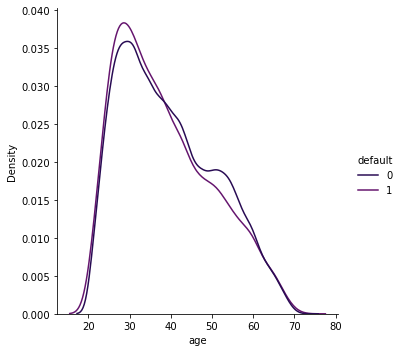

In [10]:
sns.displot(x='age', hue='default', data=df, kind='kde', common_norm=False)

In [11]:
df.groupby(['default'])['age'].agg(mean=np.mean, median=np.median, mode=pd.Series.mode)

,mean,median,mode
default,,,
0,39.390504,38.0,31
1,38.525395,36.0,26


Age distribution is skewed to the right with default = 0

<AxesSubplot:xlabel='region_rating', ylabel='education'>

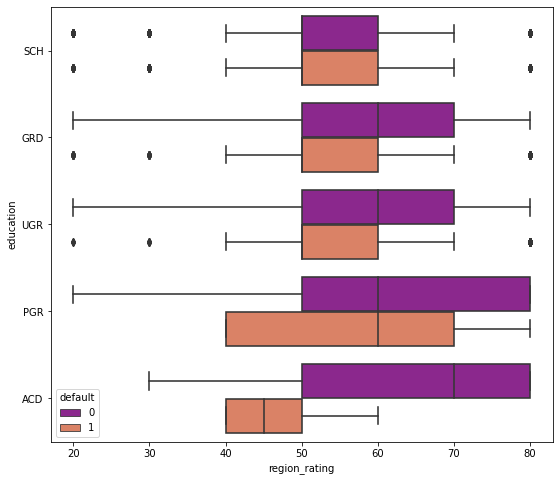

In [12]:
plt.figure(figsize=(9, 8))
sns.boxplot(x='region_rating', y='education', hue='default', data=df, 
            orient='h', palette='plasma', linewidth=1.6)

In [13]:
df.groupby(['education'])['region_rating'].std().sort_values()

education
SCH    12.321853
UGR    13.242345
GRD    13.683341
PGR    14.277761
ACD    15.192882
Name: region_rating, dtype: float64

In general, a higher rating of the region has a positive effect on loan issuance. The influence of the rating of regions for clients with ACD education is especially noticeable. For clients with a school background, the rating values are spread out over a narrower range and does not affect the decision to issue a loan

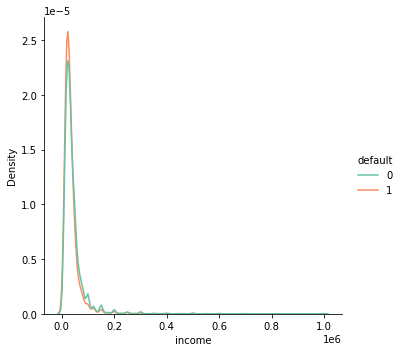

In [14]:
sns.displot(x='income', hue='default', data=df, kind='kde', common_norm=False, palette='Set2')

Income has an non-normal distribution

In [15]:
df.groupby(['default'])['income'].agg(mean=np.mean, median=np.median, mode=pd.Series.mode).reset_index() 

,default,mean,median,mode
0,0,41799.713288,30000.0,30000
1,1,36288.113316,28000.0,30000


In [16]:
df['income'] = np.log(df['income'] + 1)

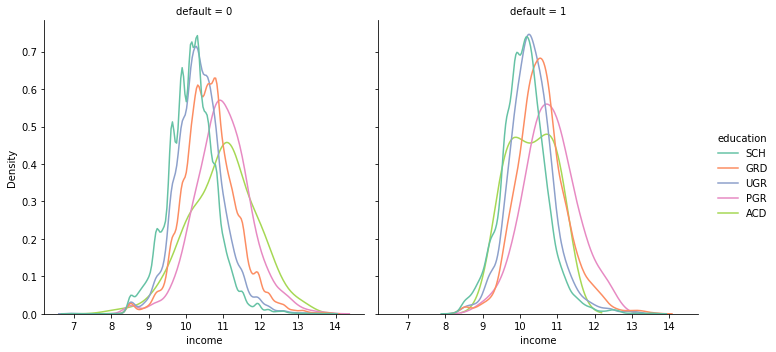

In [17]:
sns.displot(x='income', hue='education', data=df, kind='kde', common_norm=False, palette='Set2', col='default')

As the level of education rises, income rise. For clients with an advanced degree, income especially influences the decision to issue a loan (there may be a link between income and the rating of the region)

In [18]:
# filling NaN values by age
age_by_education = df['age'].groupby(df['education']).mean().to_dict()

def replace_nan(age):
    closest_age = min(age_by_education.values(), key=lambda x:abs(x - age))
    return [educ for educ, age in age_by_education.items() if age == closest_age][0]

df['education'] = [replace_nan(row['age']) if pd.isnull(row['education']) else row['education']
           for _, row in df.iterrows()]

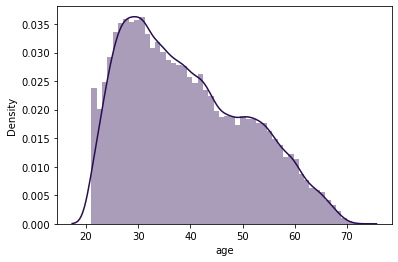

In [19]:
sns.distplot(df['age'])
df['age'] = np.log(df['age'] + 1)

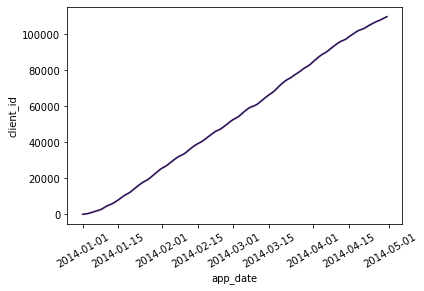

In [20]:
df['app_date'] = pd.to_datetime(df['app_date'])
g = sns.lineplot(x='app_date', y='client_id', data=df)
g.tick_params(axis='x', rotation=30)

The graph shows that the ID was compiled according to the time the application was received. This feature "client_id" has no informational value

In [21]:
df.drop('client_id', axis=1, inplace=True)

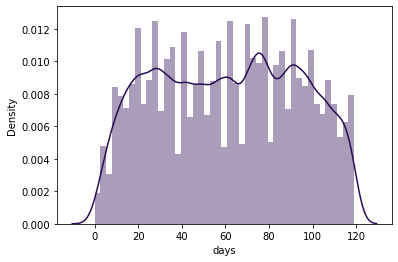

In [22]:
# creation of a new feature "days" equal to the number of days that have passed since the moment of the first fixed application
min_app_date = df['app_date'].min()
df['days'] = df['app_date'].apply(lambda x: (x - min_app_date).days)
sns.distplot(df['days'])
df.drop('app_date', axis=1, inplace=True)

<AxesSubplot:xlabel='score_bki', ylabel='Density'>

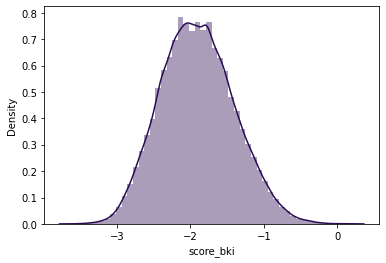

In [23]:
sns.distplot(df['score_bki'])

Feature "score_bki" is normally distributed and normalized

In [24]:
# searching a binary, categorical, numeric features
pd.DataFrame(df.nunique()).reset_index().rename({'index': 'feature', 0: 'nunique'}, axis=1).sort_values('nunique')

,feature,nunique
1,sex,2
15,foreign_passport,2
3,car,2
4,car_type,2
6,good_work,2
16,default,2
10,home_address,3
11,work_address,3
14,first_time,4
13,sna,4


In [25]:
# binary features labeling
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [26]:
# evaluation of the importance of binary features for a target variable
feature_scores = mutual_info_classif(df[bin_cols], df['default'], discrete_features=True)

for score, f_name in sorted(zip(feature_scores, df[bin_cols].columns), reverse=True):
        print(f_name, score)

foreign_passport 0.0025079594201089586
car_type 0.0017880586625307199
car 0.0009568922841248079
sex 0.00019180465509952005


In [27]:
# correlation check to exclude correlated features
df.corr().style.background_gradient(cmap='coolwarm')

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
sex,1.000000,-0.127008,0.279488,0.225578,0.020880,-0.040247,-0.045055,-0.044374,0.107711,0.037607,0.068967,0.305235,-0.003558,0.014126,0.086326,0.019619,-0.032550
age,-0.127008,1.000000,-0.037130,-0.034069,-0.117679,-0.073322,-0.109971,0.051652,-0.090973,0.000180,-0.015311,-0.092586,-0.070400,0.095163,-0.037015,-0.026119,0.017071
car,0.279488,-0.037130,1.000000,0.697939,-0.033059,0.002027,-0.044782,-0.028256,0.064685,-0.025240,-0.007523,0.324723,-0.072100,0.089959,0.107568,-0.043161,-0.022277
car_type,0.225578,-0.034069,0.697939,1.000000,-0.042907,0.017521,-0.040382,0.004147,0.104110,-0.012032,0.000506,0.369633,-0.085844,0.103973,0.145807,-0.057484,-0.027402
decline_app_cnt,0.020880,-0.117679,-0.033059,-0.042907,1.000000,-0.027359,0.189987,0.155894,-0.038505,0.012530,0.016234,-0.009723,0.065297,-0.069099,-0.026306,0.113682,-0.021352
good_work,-0.040247,-0.073322,0.002027,0.017521,-0.027359,1.000000,0.006269,0.005738,0.073041,-0.003624,-0.008535,0.051550,-0.054041,0.055821,0.046361,-0.043361,0.004665
score_bki,-0.045055,-0.109971,-0.044782,-0.040382,0.189987,0.006269,1.000000,0.156257,0.008959,0.013847,0.012648,0.002860,0.067623,-0.069122,-0.021731,0.175369,-0.063605
bki_request_cnt,-0.044374,0.051652,-0.028256,0.004147,0.155894,0.005738,0.156257,1.000000,0.009025,0.008183,0.005553,0.102479,0.005139,0.014859,0.007824,0.078242,-0.029165
region_rating,0.107711,-0.090973,0.064685,0.104110,-0.038505,0.073041,0.008959,0.009025,1.000000,0.233820,0.253541,0.312551,-0.078199,0.088777,0.255456,-0.089035,0.007125
home_address,0.037607,0.000180,-0.025240,-0.012032,0.012530,-0.003624,0.013847,0.008183,0.233820,1.000000,0.728139,0.046829,0.115196,-0.058476,0.038658,0.084637,0.164086


- Strong correlation between car and car_type. It's necessary to combine information from these columns into one column to reduce the matrix of characteristics without losing information
- Strong correlation between home_address and work_address (probably people work close to home). It's necessary to combine information from these columns into one column with vector space reducion

In [28]:
df['address'] = df['home_address'] + df['work_address']
df.drop(['home_address', 'work_address'], axis=1, inplace=True)

In [29]:
df['car_comb'] = df['car'] + df['car_type']
df.drop(['car', 'car_type'], axis=1, inplace=True)

decline_app_cnt: 2.33% outliers
bki_request_cnt: 1.69% outliers


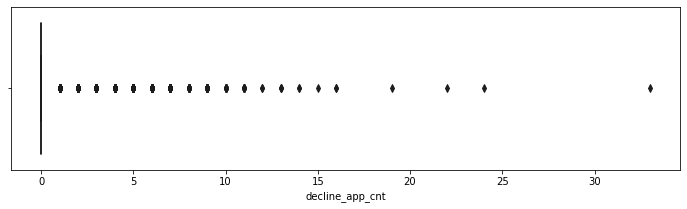

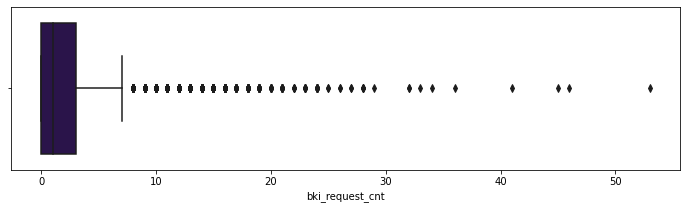

In [30]:
# checking the amount of outliers for the features 
for feature_cnt in ['decline_app_cnt', 'bki_request_cnt']:
    fig, axes = plt.subplots(figsize = (12, 3))
    sns.boxplot(df[feature_cnt],ax=axes)
    print(f"{feature_cnt}: {get_percent_outliers(df[feature_cnt])}")

In [31]:
# creation of a new categorical feature to eliminate outliers
for feature_cnt in ['decline_app_cnt', 'bki_request_cnt']:
    feature_cnt_out = get_outliers(df[feature_cnt])
    min_out = min(feature_cnt_out)
    # making outliers equal to the last non-outlier value
    df[f'{feature_cnt}_cat'] = [min_out if row[feature_cnt] in feature_cnt_out else 
                                row[feature_cnt] for _, row in df.iterrows()]

df.drop('decline_app_cnt', axis=1, inplace=True)
df.drop('bki_request_cnt', axis=1, inplace=True)

In [32]:
# saving the dataframe without transforming categorical variables for the catboost algorithm
df_cat = df.copy()

cat_cols = ['education', 'region_rating', 'sna', 'first_time', 
            'car_comb', 'decline_app_cnt_cat', 'bki_request_cnt_cat', 'address']

#convert categorical variable into dummy variables
df = pd.get_dummies(data=df, columns=cat_cols)

In [33]:
# evaluation of the importance of numeric features for a target variable
num_cols = ['income', 'days', 'age']

feature_scores = mutual_info_classif(df[num_cols], df['default'], discrete_features=True)
for score, f_name in sorted(zip(feature_scores, df[num_cols].columns), reverse=True):
    print(f_name, score)

income 0.007951833068387787
days 0.0019904768036756943
age 0.0007086033986708519


In [34]:
# standardization of numeric features
scaler = StandardScaler()

for col in num_cols:
    df[col] = scaler.fit_transform(df[[col]])

## Modeling

In the dataset, there is an imbalance in the target feature. With unbalanced data, the "accuracy" metric cannot be trusted. To overcome this will help the transition from a common metric for all classes to separate indicators of the quality of classes. Thus, we will focus on the roc-auc score when comparing models. 
What metric is better to focus on is a question to the bank. If it is more profitable for a bank to issue more loans (including bad clients), then it is better to increase the "precision". If it is critical for the bank to identify as many bad borrowers as possible, it is better to focus on the "recall" (most often)

In [35]:
# iteratively finding the best subset of features by recursive feature elimination using a logistic regression model
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Stratified K-Folds cross-validation for unbalanced classes
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# indication of class imbalance using the 'class_weight' parameter
estimator = LogisticRegression(class_weight='balanced')
# automatic determination of the required number of features
rfe = RFECV(estimator, min_features_to_select=10, cv=cv)
rfe.fit(X_train, y_train)

# splitting data with fewer features
X = df.loc[:, X.columns[rfe.support_]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': [100, 10, 1.0, 0.1, 0.01],
          'penalty': ['l2']}

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)

lr = GridSearchCV(lr_model, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)
lr.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [37]:
lr_model = LogisticRegression(**lr.best_params_, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_score = lr_model.predict_proba(X_test)[:,1]

In [38]:
# creating a dataframe for comparing metrics of different models
model_metrics = pd.DataFrame(index=['accuracy', 'roc-auc', 'precision', 'recall', 'f1'], 
                       data = {'LogReg': [accuracy_score(y_test, lr_pred),
                                               roc_auc_score(y_test, lr_score), 
                                               precision_score(y_test, lr_pred),
                                               recall_score(y_test, lr_pred),
                                               f1_score(y_test, lr_pred)]})
model_metrics

,LogReg
accuracy,0.670596
roc-auc,0.744354
precision,0.226231
recall,0.686371
f1,0.340299


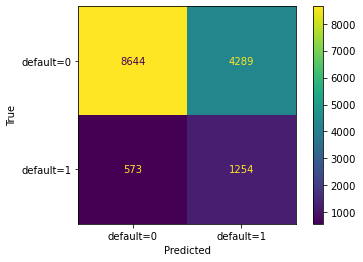

In [39]:
# check a confusion matrix
g = plot_confusion_matrix(lr, X_test, y_test, display_labels=['default=0','default=1'])
g.ax_.set(xlabel='Predicted', ylabel='True')

plt.show()

The basic logistic classifier has a fairly high recall and a low precision value. The classifier is better suited for situations where the error of non-default is high

In [40]:
params = {'max_depth': [10, 15, 20],
          'n_estimators': [500, 1000, 2000],
          'max_leaf_nodes': [15, 20],
          'min_samples_leaf': [7, 10, 20], 
          'max_features': ['log2', 'sqrt'],
          'criterion': ['gini', 'entropy']}

rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED)

rf = RandomizedSearchCV(rf_model, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1, n_iter=5)
rf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'max_leaf_nodes': [15, 20],
                                        'min_samples_leaf': [7, 10, 20],
                                        'n_estimators': [500, 1000, 2000]},
                   scoring='roc_auc', verbose=2)

In [41]:
# model with the best parameters
rf_model = RandomForestClassifier(**rf.best_params_, class_weight='balanced', random_state=RANDOM_SEED)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_score = rf_model.predict_proba(X_test)[:, 1]

model_metrics['RandomForest'] = [accuracy_score(y_test, rf_pred), roc_auc_score(y_test, rf_score), 
                            precision_score(y_test, rf_pred), recall_score(y_test, rf_pred), f1_score(y_test, rf_pred)]
model_metrics

,LogReg,RandomForest
accuracy,0.670596,0.647154
roc-auc,0.744354,0.722714
precision,0.226231,0.212549
recall,0.686371,0.684182
f1,0.340299,0.324338


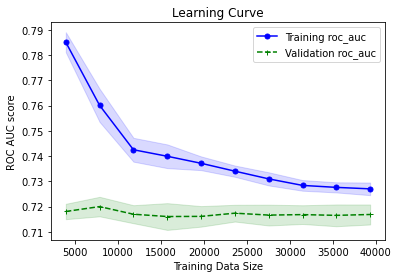

In [42]:
# overfitting check
train_sizes, train_scores, test_scores = learning_curve(estimator=rf_model, X=X_train, y=y_train,
                                                       cv=cv, train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        n_jobs=-1, scoring='roc_auc')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training roc_auc')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation roc_auc')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve')

plt.xlabel('Training Data Size')
plt.ylabel('ROC AUC score')

plt.legend(loc='upper right')

plt.show()

The roc auc score for the Random Forest classifier is smaller

In [43]:
# class weight calculation
k_train = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
wt = dict(zip(np.unique(y_train), k_train))
w_array = y_train.map(wt)

In [44]:
params = {'max_depth': [3, 5],
          'n_estimators': [50, 100, 200],
          'learning_rate': [0.001, 0.01, 0.1, 0.2],
          'max_leaf_nodes': [15, 20],
          'min_samples_leaf': [1, 3, 5],
          'max_features': ['log2', 'sqrt']}

gb_model = GradientBoostingClassifier(random_state=RANDOM_SEED)

gb = GridSearchCV(gb_model, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)
gb.fit(X_train, y_train, sample_weight=w_array.values)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 5], 'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [15, 20],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=2)

In [45]:
gb_model = GradientBoostingClassifier(**gb.best_params_)
gb_model.fit(X_train, y_train, sample_weight=w_array.values)

gb_pred = gb_model.predict(X_test)
gb_score = gb_model.predict_proba(X_test)[:,1]

model_metrics['GradientBoost'] = [accuracy_score(y_test, gb_pred), roc_auc_score(y_test, gb_score), 
                            precision_score(y_test, gb_pred), recall_score(y_test, gb_pred), f1_score(y_test, gb_pred)]
model_metrics

,LogReg,RandomForest,GradientBoost
accuracy,0.670596,0.647154,0.669851
roc-auc,0.744354,0.722714,0.744111
precision,0.226231,0.212549,0.225684
recall,0.686371,0.684182,0.685824
f1,0.340299,0.324338,0.339612


Gradient Boosting classifier shows better results than Random Forest

In [46]:
params = {'max_depth': [3, 5, 7],
          'n_estimators': [200, 500, 1000],
          'learning_rate': [0.001, 0.01, 0.1],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.5, 0.7, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0]}

xgb_model = XGBClassifier(scale_pos_weight=7, objective='binary:logistic',
                          use_label_encoder=False, random_state=RANDOM_SEED)

xgb = RandomizedSearchCV(xgb_model, params, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2, n_iter=5)
xgb.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[12:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                                           scale_pos_weight=7, subsample=None,
                                           tree_method=None,
                                           use_label_encoder=False,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [200, 500, 1000],
                                        'subsample': [0.5, 0.7, 1.0]},
                   scoring='roc_auc', verbose=2)

In [47]:
xgb_model = XGBClassifier(**xgb.best_params_, scale_pos_weight=7, objective='binary:logistic',
                          use_label_encoder=False, random_state=RANDOM_SEED) 
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_score = xgb_model.predict_proba(X_test)[:,1]

model_metrics['XGBoost'] = [accuracy_score(y_test, xgb_pred), roc_auc_score(y_test, xgb_score), 
                            precision_score(y_test, xgb_pred), recall_score(y_test, xgb_pred), f1_score(y_test, xgb_pred)]
model_metrics

[12:37:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,LogReg,RandomForest,GradientBoost,XGBoost
accuracy,0.670596,0.647154,0.669851,0.686789
roc-auc,0.744354,0.722714,0.744111,0.739427
precision,0.226231,0.212549,0.225684,0.230532
recall,0.686371,0.684182,0.685824,0.654625
f1,0.340299,0.324338,0.339612,0.340984


Extreme Gradient Boosting shows the good roc-auc score

In [48]:
X = df_cat.drop('default', axis=1)
y = df_cat['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

params = {'n_estimators': [100, 300, 500],
          'max_depth': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 0.2], 
          'l2_leaf_reg': [5, 7, 9]}

catb_model = CatBoostClassifier(scale_pos_weight=7, logging_level='Silent',
                                allow_writing_files=False, random_state=RANDOM_SEED)
catb = GridSearchCV(catb_model, params, scoring='roc_auc', cv=cv, n_jobs=-1)

catb.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(i) for i in cat_cols], eval_set=(X_test, y_test))

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc2fa5b6fa0>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [5, 7, 9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [49]:
catb_model = CatBoostClassifier(**catb.best_params_, scale_pos_weight=7, logging_level='Silent',
                                 allow_writing_files=False, random_state=RANDOM_SEED)

catb_model.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(i) for i in cat_cols],
         eval_set=(X_test, y_test), verbose=False)

catb_pred = catb_model.predict(X_test)
catb_score = catb_model.predict_proba(X_test)[:, 1]

model_metrics['CatBoost'] = [accuracy_score(y_test, catb_pred), roc_auc_score(y_test, catb_score), 
                             precision_score(y_test, catb_pred), recall_score(y_test, catb_pred), 
                             f1_score(y_test, catb_pred)]
model_metrics

,LogReg,RandomForest,GradientBoost,XGBoost,CatBoost
accuracy,0.670596,0.647154,0.669851,0.686789,0.674322
roc-auc,0.744354,0.722714,0.744111,0.739427,0.745289
precision,0.226231,0.212549,0.225684,0.230532,0.228301
recall,0.686371,0.684182,0.685824,0.654625,0.685276
f1,0.340299,0.324338,0.339612,0.340984,0.342498


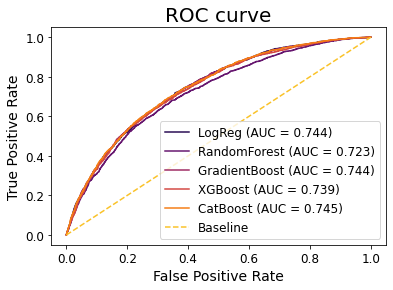

In [50]:
# comparison of ROC-curves
fpr, tpr, thresholds = roc_curve(y_test, lr_score)
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc_score(y_test, lr_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, rf_score)
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc_score(y_test, rf_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, gb_score)
plt.plot(fpr, tpr, label=f'GradientBoost (AUC = {roc_auc_score(y_test, gb_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, xgb_score)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, catb_score)
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_score(y_test, catb_score):.3f})')

plt.plot([0, 1], label='Baseline', linestyle='--')

plt.title('ROC curve', fontsize=20)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=12)

plt.show()

Catboost has the highest roc auc score

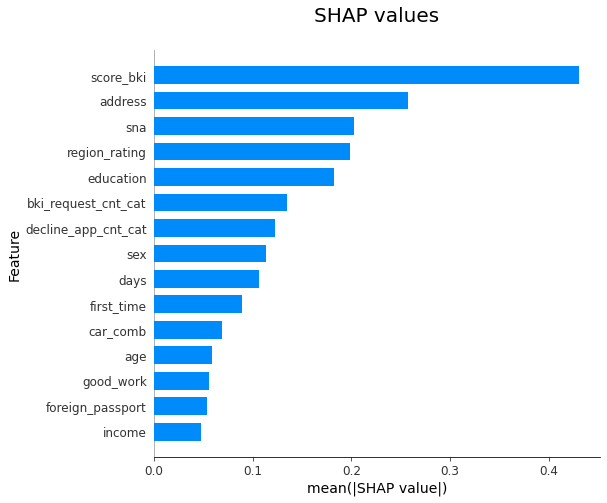

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END criterion=entropy, max_depth=15, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, n_estimators=2000; total time=  44.4s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=3, n_estimators=100; total time=   2.3s
[CV] END learning_

[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=20, n_estimators=500; total time=  13.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=7, n_estimators=1000; total time=  25.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END criterion=entropy, max_depth=15, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, n_estimators=2000; total time=  44.4s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=200; total time=   4.5s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=3, n_estimators=200; total time=   5.5s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  10.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=20, n_estimators=500; total time=  13.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  13.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=3, max_fea

[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END criterion=entropy, max_depth=15, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, n_estimators=2000; total time=  44.4s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=3, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=3,

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=20, n_estimators=500; total time=  13.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  11.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  13.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.001, max_depth=3, max_fe

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  10.7s
[CV] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=7, n_estimators=1000; total time=  24.8s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=3, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=3, max_f

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_leaf=20, n_estimators=500; total time=  10.7s
[CV] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=15, min_samples_leaf=7, n_estimators=1000; total time=  24.7s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=1, n_estimators=200; total time=   4.6s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, max_leaf_nodes=15, min_samples_leaf=5, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=3, max_

In [52]:
# feature importances using SHAP values
explainer = shap.TreeExplainer(catb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

plt.title('SHAP values\n', fontsize=20)
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()